In [1]:
import os

import tensorflow as tf
from tensorflow.keras import Model, callbacks
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D,
                                     Input)
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Convolution2D,Activation,Flatten,Dense,Dropout,MaxPool2D,BatchNormalization


try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
test_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
print("Total disease classes are: {}".format(len(diseases)))

train_datagen_aug = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode="nearest",
                                   rotation_range = 20,
                                   width_shift_range=0.2,
                                    height_shift_range=0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2) # set validation split


test_datagen_aug = ImageDataGenerator( rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 20,
                                   horizontal_flip = True)


training_set_aug = train_datagen_aug.flow_from_directory(directory= train_dir,
                                               target_size=(224, 224), # As we choose 64*64 for our convolution model
                                               batch_size=128,
                                               class_mode='categorical',
                                               subset='training')


validation_set_aug = train_datagen_aug.flow_from_directory(directory= train_dir,
                                               target_size=(224, 224), # As we choose 64*64 for our convolution model
                                               batch_size=128,
                                               class_mode='categorical',
                                               subset='validation',
                                               shuffle=False)

label_map = (training_set_aug.class_indices)
print("Target Classes Mapping Dict:\n")
print(label_map)
label_map = (validation_set_aug.class_indices)
print("Target Classes Mapping Dict:\n")
print(label_map)


test_set_aug = test_datagen_aug.flow_from_directory(directory= test_dir,
                                               target_size=(224, 224), # As we choose 64*64 for our convolution model
                                               batch_size=128,
                                               class_mode='categorical') # for 2 class binary
label_map = (test_set_aug.class_indices)
print("Target Classes Mapping Dict:\n")
print(label_map)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Number of accelerators:  2
Total disease classes are: 38
Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.
Target Classes Mapping Dict:

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___P

In [2]:
with strategy.scope():
    # Instantiate an empty sequential model
    model = Sequential(name="Alexnet")
    # 1st layer (conv + pool + batchnorm)
    model.add(Conv2D(filters= 96, kernel_size= (11,11), strides=(4,4), padding='valid', kernel_regularizer=l2(0.0005), input_shape = (224,224,3)))
    model.add(Activation('relu'))  #<---- activation function can be added on its own layer or within the Conv2D function
    model.add(MaxPool2D(pool_size=(3,3), strides= (2,2), padding='valid'))
    model.add(BatchNormalization())
        
    # 2nd layer (conv + pool + batchnorm)
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())
                
    # layer 3 (conv + batchnorm)      <--- note that the authors did not add a POOL layer here
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
            
    # layer 4 (conv + batchnorm)      <--- similar to layer 3
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
                
    # layer 5 (conv + batchnorm)  
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

    # Flatten the CNN output to feed it with fully connected layers
    model.add(Flatten())

    # layer 6 (Dense layer + dropout)  
    model.add(Dense(units = 4096, activation = 'relu'))
    model.add(Dropout(0.5))

    # layer 7 (Dense layers) 
    model.add(Dense(units = 4096, activation = 'relu'))
    model.add(Dropout(0.5))
                              
    # layer 8 (softmax output layer) 
    model.add(Dense(units = 38, activation = 'softmax'))

    print(model.summary())
    
    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy',TopKCategoricalAccuracy(k=1, name="top1")])

Model: "Alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 26, 26, 256)       0   

In [3]:
early_stopping_cb = callbacks.EarlyStopping(monitor="val_loss", patience=3)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                              factor=0.2, 
                                              patience=2,
                                              verbose=1, 
                                              min_lr=1e-7)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor="val_loss")

history = model.fit(training_set_aug,
                    epochs=20,
                    verbose=1,
                    callbacks=[early_stopping_cb, model_checkpoint, reduce_lr],
                    validation_data = validation_set_aug, 
                    # steps_per_epoch = 20,
                    # validation_steps = 20
                    )

Epoch 1/20
440/440 [==============================] - 1446s 3s/step - loss: 3.6074 - accuracy: 0.2972 - top_k_categorical_accuracy: 0.6533 - top1: 0.2972 - val_loss: 4.1258 - val_accuracy: 0.1937 - val_top_k_categorical_accuracy: 0.5071 - val_top1: 0.1937 - lr: 0.0010
Epoch 2/20
440/440 [==============================] - 960s 2s/step - loss: 2.0051 - accuracy: 0.5395 - top_k_categorical_accuracy: 0.8771 - top1: 0.5395 - val_loss: 4.1705 - val_accuracy: 0.2154 - val_top_k_categorical_accuracy: 0.5676 - val_top1: 0.2154 - lr: 0.0010
Epoch 3/20
440/440 [==============================] - ETA: 0s - loss: 1.5221 - accuracy: 0.6531 - top_k_categorical_accuracy: 0.9323 - top1: 0.6531
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
440/440 [==============================] - 931s 2s/step - loss: 1.5221 - accuracy: 0.6531 - top_k_categorical_accuracy: 0.9323 - top1: 0.6531 - val_loss: 4.4918 - val_accuracy: 0.2683 - val_top_k_categorical_accuracy: 0.5330 - val_top1: 0

In [5]:
model.load_weights(checkpoint_path)
model.evaluate(test_set_aug)

138/138 [==============================] - 308s 2s/step - loss: 0.1652 - accuracy: 0.9855 - top_k_categorical_accuracy: 0.9994 - top1: 0.9855


[0.16521194577217102,
 0.9854882955551147,
 0.9994308948516846,
 0.9854882955551147]

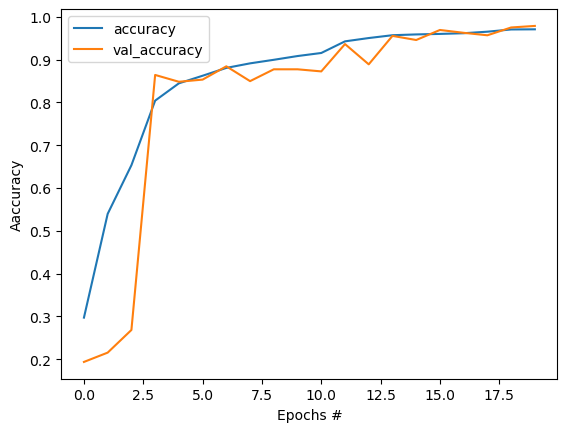

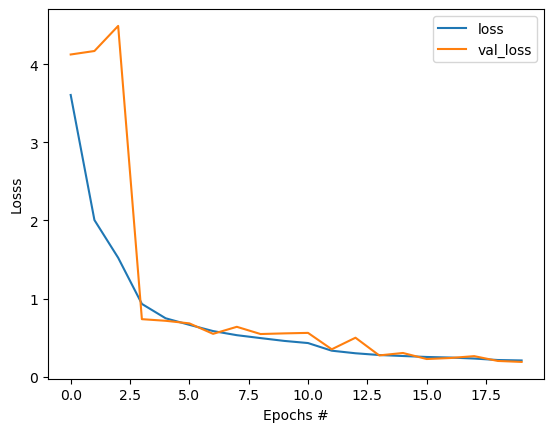

In [6]:
# Plotting
hist = history.history
def show_plt(type):
    if type == 1:
        plt.plot(hist["accuracy"], label="accuracy")
        plt.plot(hist["val_accuracy"], label="val_accuracy")
        plt.ylabel("Aaccuracy")
        plt.xlabel("Epochs #")
        plt.legend()
        plt.show()
    else:
        plt.plot(hist["loss"], label="loss")
        plt.plot(hist["val_loss"], label="val_loss")
        plt.ylabel("Losss")
        plt.xlabel("Epochs #")
        plt.legend()
        plt.show()
        
show_plt(1)
show_plt(0)

In [24]:
# reset the test_data to start iterating over dataset from scratch
validation_set_aug.reset()
# start to predict
pred = classifier.predict(validation_set_aug)

110/110 [==============================] - 197s 2s/step


In [27]:
final_predict = np.argmax(pred,axis=1)
true_data=validation_set_aug.classes

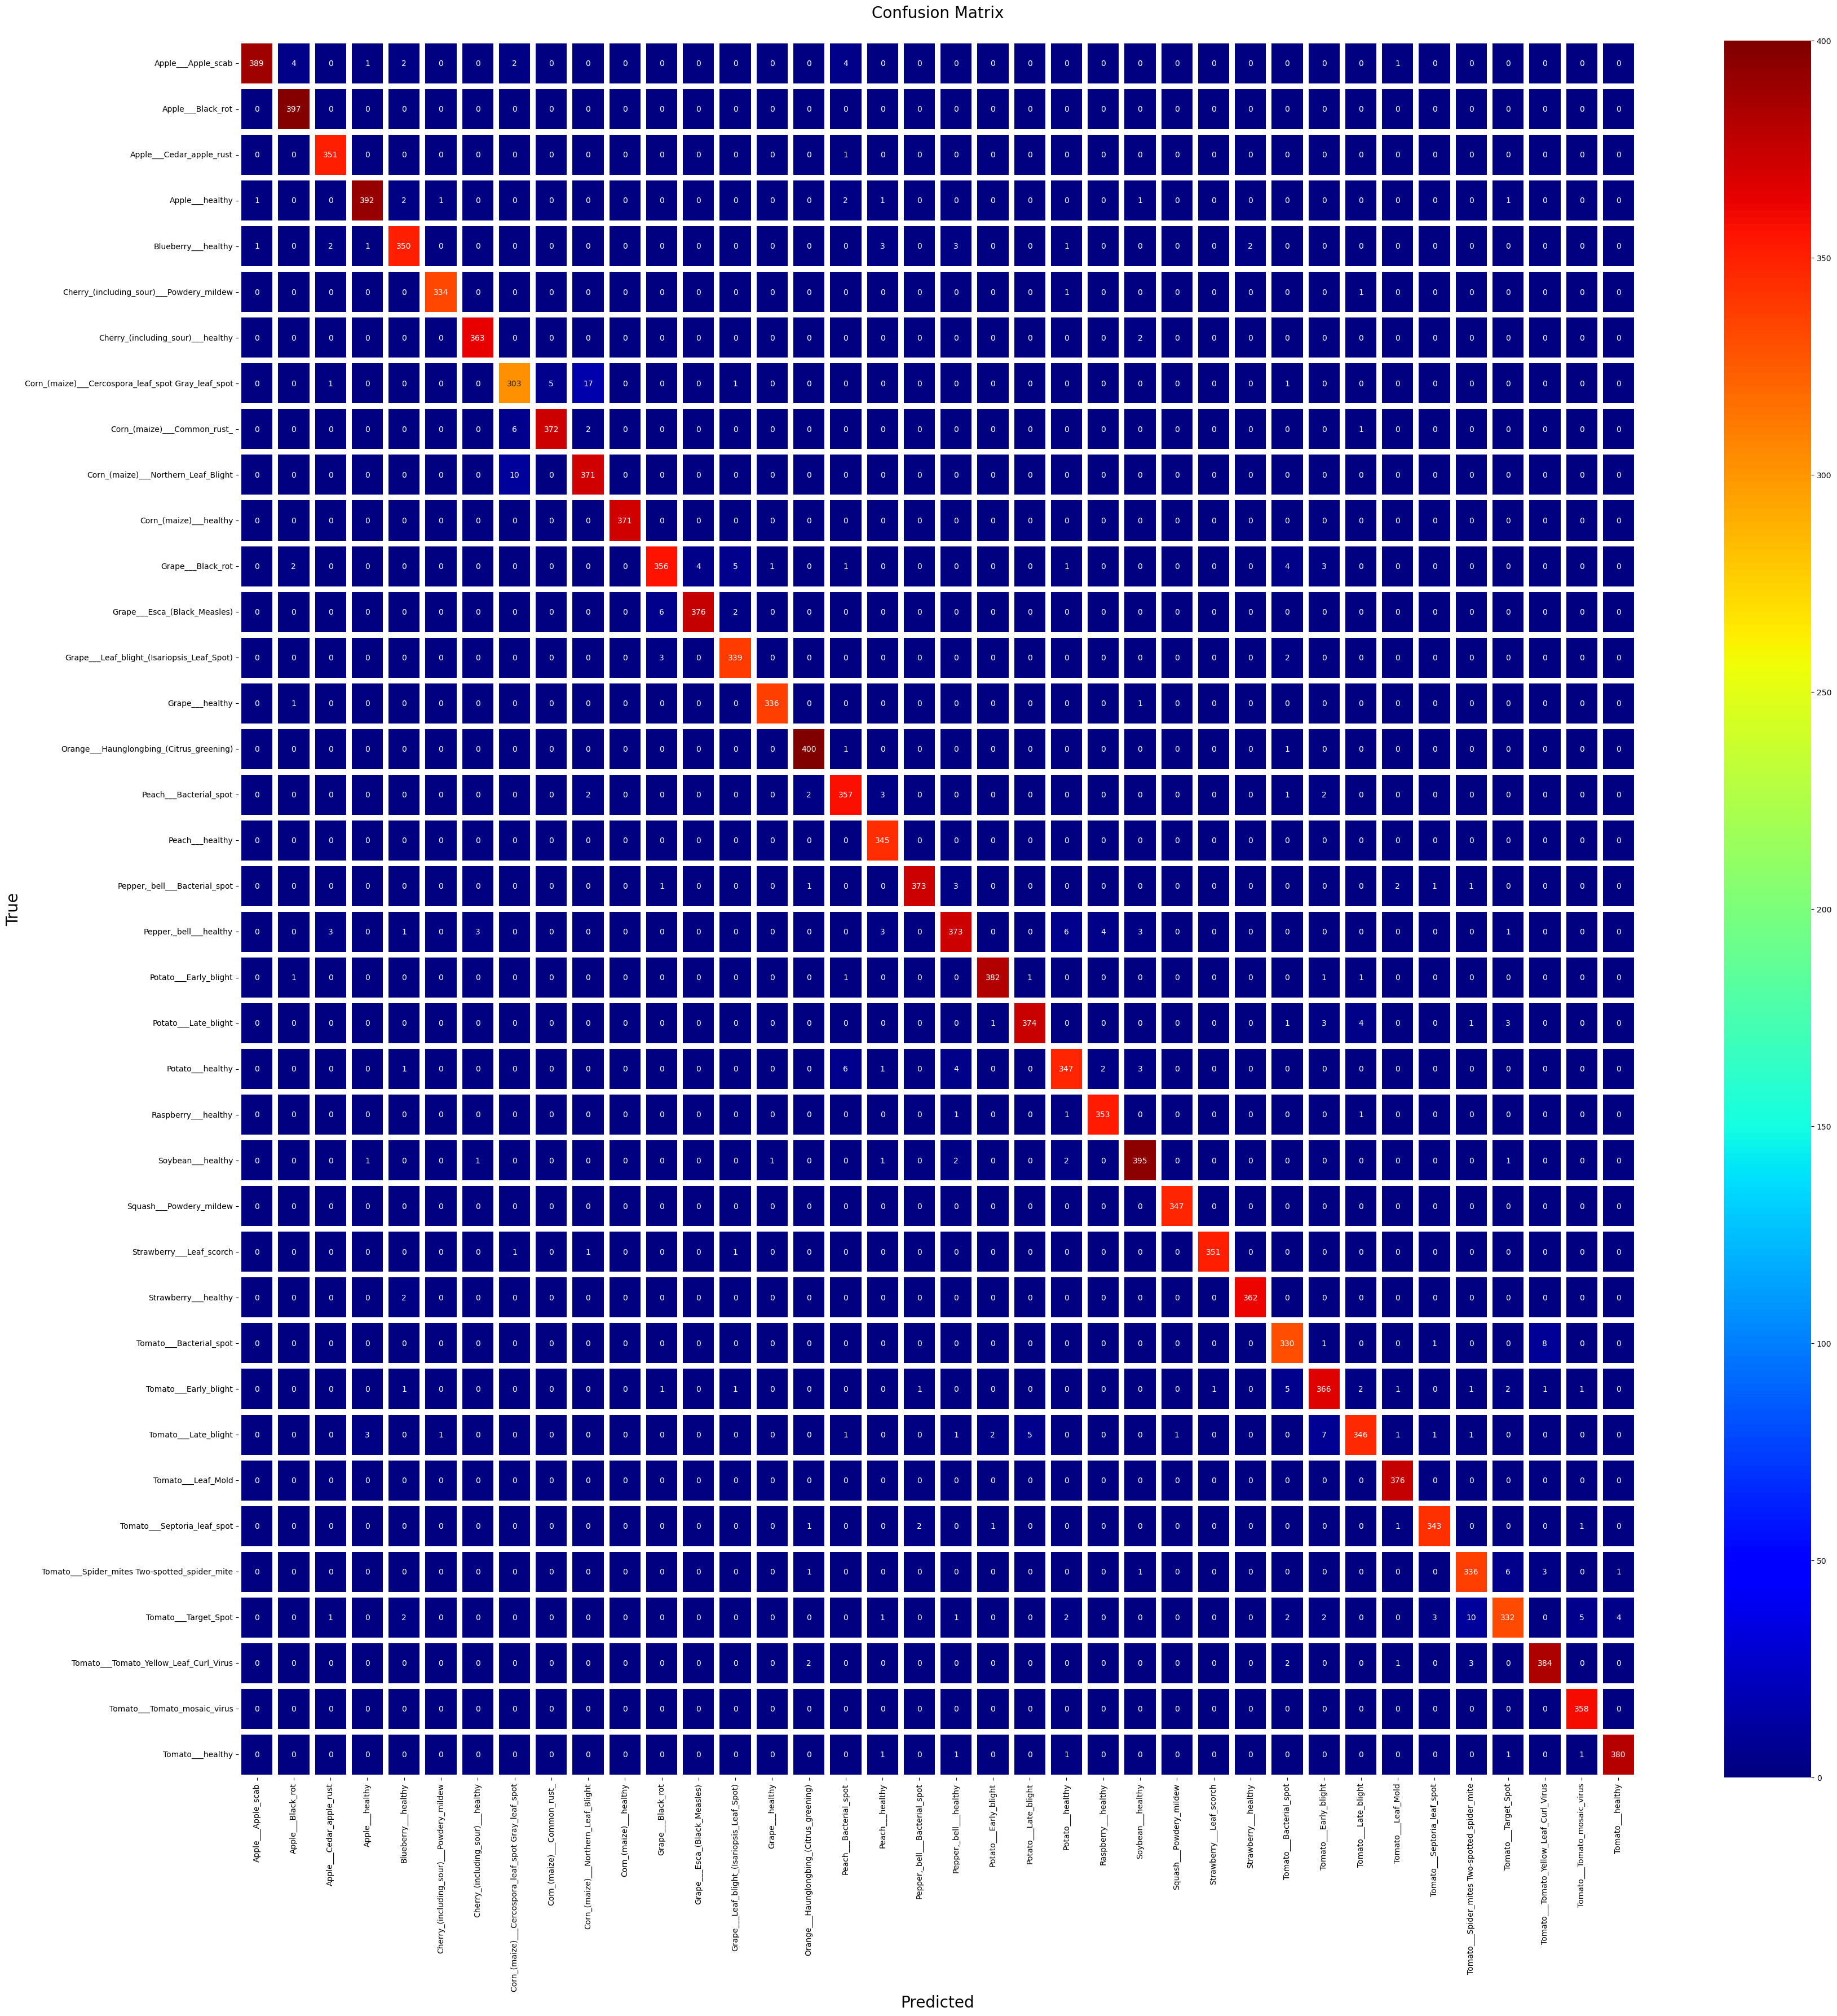

In [32]:
import seaborn as sns
plt.figure(figsize=(40,40))
confusion = confusion_matrix(true_data, final_predict)
sns.heatmap(confusion, annot=True, fmt='d', cmap='jet',xticklabels=label_map,
            yticklabels=label_map,lw=6)
plt.xlabel('Predicted',fontsize=20,color="black")
plt.ylabel('True',fontsize=20,color="black")
plt.title('Confusion Matrix\n',fontsize=20,color="black")
plt.show()

In [33]:
print(classification_report(true_data, final_predict,target_names=label_map))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.97      0.98       403
                                 Apple___Black_rot       0.98      1.00      0.99       397
                          Apple___Cedar_apple_rust       0.98      1.00      0.99       352
                                   Apple___healthy       0.98      0.98      0.98       401
                               Blueberry___healthy       0.97      0.96      0.97       363
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       336
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99       365
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.92      0.93       328
                       Corn_(maize)___Common_rust_       0.99      0.98      0.98       381
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.97      0.

In [34]:
acc_score = accuracy_score(true_data,final_predict)
print(f'Accuracy Score: {acc_score:.4f}')

Accuracy Score: 0.9762


In [35]:
class_dict = training_set_aug.class_indices
print(class_dict)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight': 30, 'Tomato

In [36]:
li = list(class_dict.keys())
print(li)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

Following is our prediction:
1/1 [==============================] - 1s 746ms/step


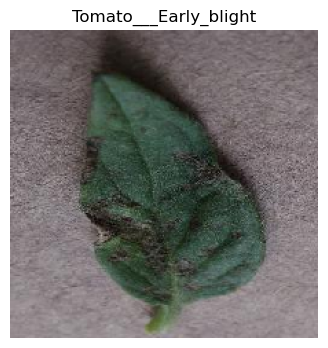

In [37]:
# predicting an image
from tensorflow.keras.preprocessing import image
import numpy as np
image_path = "/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight6.JPG"
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255

print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = li[index]

##Another way
#img_class = classifier.predict_classes(img)
#img_prob = classifier.predict_proba(img)
#print(img_class ,img_prob )


#ploting image with predicted class name        
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()

In [39]:
#saving model
filepath="AlexNetModel.hdf5"
model.save(filepath)